# Soil Type Classification using Convolutional Neural Network

In [1]:
train_data_directory = 'new_image_dataset/train'
test_data_directory = 'new_image_dataset/test'

In [2]:
import os # operating system
import re # regular expression
import cv2 # open cv
import time
import numpy as np
from os import listdir
from os.path import isfile, join
from random import randrange # random range
import matplotlib.pyplot as plt
import tensorflow as tf

load_model = tf.keras.models.load_model
image = tf.keras.preprocessing.image
ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator
Sequential = tf.keras.models.Sequential
Dense = tf.keras.layers.Dense
Activation = tf.keras.layers.Activation
Flatten = tf.keras.layers.Flatten
Conv2D = tf.keras.layers.Conv2D
MaxPooling2D = tf.keras.layers.MaxPooling2D

In [3]:
# initiate data preprocessing tools

# This step processes the images into a format that
# 1. makes the data readable to the model
# 2. provides more training material for the model to train from
# the `training_data_processor` below scales the data so that it can be
# a model input, but also takes each image and augments it so that
# the model can learn from multiple variations of the same image.
# it flips it horizontally, rotates it, shifts it, and more so that 
# the model learns from the soil photo rather than the orientation size
training_data_processor  = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    zoom_range = 0.2,
    rotation_range = 10,
    shear_range = 0.2,
    height_shift_range = 0.1,
    width_shift_range = 0.1,
)
# for the testing images, we don't need to create multiple variatinos
test_data_processor = ImageDataGenerator(rescale=1./255)


# load data into python

training_data = training_data_processor.flow_from_directory(
    train_data_directory,
    target_size = (256, 256), # pixels
    batch_size = 32,
    class_mode = 'categorical',
)

testing_data = test_data_processor.flow_from_directory(
    test_data_directory,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

Found 200 images belonging to 5 classes.
Found 40 images belonging to 5 classes.


## Model building

In [4]:
# choose model parameters
num_conv_layers = 3
num_dense_layers = 2
layer_size = 29 # limit the layer size as we dont want to over fit the model
num_training_epochs = 20
MODEL_NAME = 'soil_classifier'

CLASSES = ['clay', 'gravel', 'humus', 'sand', 'silt']

In [10]:
# initiate model variable
model = Sequential()

# begin adding properties to model variable
# e.g. add a convulutional layer
model.add(Conv2D(layer_size, (3,3), input_shape=(256, 256, 3)))
model.add(Activation('relu')) # rectified linear unit
model.add(MaxPooling2D(pool_size=(2,2)))

# add additional convolutional layers based on num_conv_layers
for _ in range(num_conv_layers-1):
    model.add(Conv2D(layer_size, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

# reduce dimensionality
model.add(Flatten())

# add fully connected "dense" layers if specified
for _ in range(num_dense_layers):
    model.add(Dense(layer_size))
    model.add(Activation('relu'))

# output layer
model.add(Dense(len(CLASSES)))
model.add(Activation('softmax'))

# compile the sequential model with all added properties
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

# use the data already loaded to train/tune the model
model.fit(
    training_data, 
    epochs = num_training_epochs, 
    validation_data = testing_data)

# save the trained model
model.save(f'{MODEL_NAME}.h5')

Epoch 1/20
7/7 [==============================] - 13s 2s/step - loss: 1.5013 - accuracy: 0.2850 - val_loss: 1.3113 - val_accuracy: 0.4250
Epoch 2/20
7/7 [==============================] - 14s 2s/step - loss: 1.1517 - accuracy: 0.4400 - val_loss: 0.9563 - val_accuracy: 0.5000
Epoch 3/20
7/7 [==============================] - 14s 2s/step - loss: 0.9831 - accuracy: 0.5600 - val_loss: 1.0259 - val_accuracy: 0.4750
Epoch 4/20
7/7 [==============================] - 14s 2s/step - loss: 0.9161 - accuracy: 0.5650 - val_loss: 0.9831 - val_accuracy: 0.4500
Epoch 5/20
7/7 [==============================] - 11s 1s/step - loss: 0.9389 - accuracy: 0.5600 - val_loss: 0.8322 - val_accuracy: 0.5250
Epoch 6/20
7/7 [==============================] - 7s 912ms/step - loss: 0.8394 - accuracy: 0.5750 - val_loss: 0.6610 - val_accuracy: 0.7000
Epoch 7/20
7/7 [==============================] - 7s 914ms/step - loss: 0.6526 - accuracy: 0.7150 - val_loss: 0.5603 - val_accuracy: 0.9000
Epoch 8/20
7/7 [==============

In [5]:
def classify(image_fp):
    im = cv2.imread(image_fp) # load the image from the given file path (image_fp)
    plt.imshow(im[:,:,[2,1,0]]) # swap the colors because open-cv swaps the rgb colors
    img = image.load_img(image_fp, target_size = (256, 256))
    img = image.img_to_array(img)

    image_array = img / 255. # scale the image
    img_batch = np.expand_dims(image_array, axis = 0)

    class_ = CLASSES # possible output values
    from tensorflow import keras
    model = keras.models.load_model('soil_classifier.h5')
    predicted_value = model.predict(img_batch)

    accuracy = model.evaluate(training_data)
    
    out  = f"""
      clay: {predicted_value[0][0]:.5f}
    gravel: {predicted_value[0][1]:.5f}
     humus: {predicted_value[0][2]:.5f}
      peat: {predicted_value[0][3]:.5f}
      peat: {predicted_value[0][4]:.5f}

    Result: {(predicted_value[0][predicted_value.argmax()] * 100):.2f}% {class_[predicted_value.argmax()]}

  accuracy: {(accuracy[1]*100):.5f}
      loss: {(accuracy[0]*100):.5f}
    """
    return out

7/7 [==============================] - 3s 445ms/step - loss: 0.1403 - accuracy: 0.9350

      clay: 0.00000
    gravel: 0.02926
     humus: 0.00008
      peat: 0.96712
      peat: 0.00355

    Result: 96.71% sand

    accuracy: 93.50000
    loss: 14.03317
    


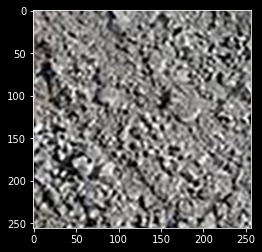

In [18]:
test_image_file_path = test_data_directory + '/sand/OIP (1).jpg'
test_prediction = classify(test_image_file_path)

print(test_prediction)